In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import shapely
import cv2
from PIL import Image
import argparse
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import polygon_primitives.file_writer as fw

from image_processing import extract_window_wall_ratio, utils, contour_extraction
from scipy.spatial import Delaunay
from common.colors import continuous_palette_for_color

In [2]:
%pwd

'/Users/akprakash/Programming/autobfe/a3dbr/Example_Notebooks'

First, we set the image and parameter directories, as well as the merged polygons file path. We load the merged polygons, as we also initialize a dictionary for the Cameras. The Camera class stores all information related to the camera, i.e. intrinsic and extrinsic camera parameters.

In [3]:
#Example file
mapped_files = ["DJI_0047.JPG", "DJI_0026.JPG", "DJI_0055.JPG", "DJI_0131.JPG", "DJI_0012.JPG"]
# filename = "DJI_0026.JPG" ## good
filename = "DJI_0047.JPG" ## good
# filename = "DJI_0027.JPG"

directory = "/Users/akprakash/Programming/autobfe/blume/"
facade_file = directory+ "blume_merged_polygons.txt"

image_dir = directory + "rgb/"
param_dir = directory + "params/"
predictions_dir = directory + "probs/"
predictions_dir2 = directory + "probs2/"

offset = np.loadtxt(directory + "blume_polygon_offset.txt",usecols=range(3), delimiter=',')

#Initializes a dictionary of Camera classes. See utils.py for more information.
camera_dict = utils.create_camera_dict(param_dir, filename='merged_blume2_calibrated_camera_parameters.txt', offset=offset)

#Loads pmatrices and image filenamees
p_matrices = np.loadtxt(param_dir + 'merged_blume2_pmatrix.txt', usecols=range(1,13))

#Loads the merged polygons, as well as a list of facade types (i.e. roof, wall, or floor)
merged_polygons, facade_type_list, file_format = fw.load_merged_polygon_facades(filename=facade_file)

#Offset adjustment parameter
height_adj = np.array([0.0, 0.0, 108])
offset = offset + height_adj


Next, we extract the contours for the window predictions, by taking the window prediction points and using them to create a shapely polygon.

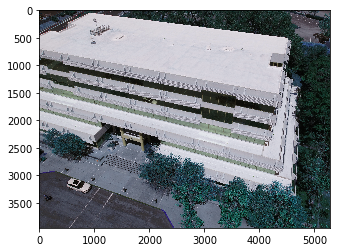

In [4]:
image_file = image_dir + filename

image = cv2.imread(image_file)
plt.imshow(image)
plt.show()

Window predictions: 


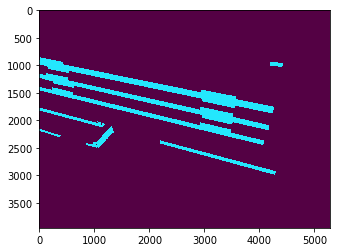

(3956, 5280, 3)


In [5]:
window_file = predictions_dir + filename.split(".")[0] +".png"

print("Window predictions: ")
pred_image = cv2.imread(window_file)
plt.imshow(pred_image)
plt.show()
print(pred_image.shape)

In [8]:
new_pred_image = []
for x in pred_image:
    new_y = []
    for y in x:
        if not np.array_equal(y, np.array([84, 1, 68])):
            new_y.append(np.array([89, 0, 237]))
        else: 
            new_y.append(np.array([236, 237, 237]))
    new_pred_image.append(np.array(new_y))

KeyboardInterrupt: 

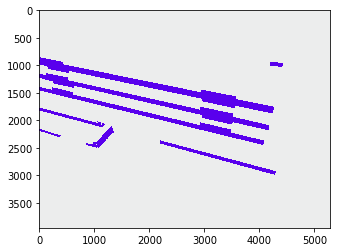

In [46]:
pred_image2 = np.array(new_pred_image, dtype='uint8')

from PIL import Image
im = Image.fromarray(pred_image2)
plt.imshow(im)
im.save(predictions_dir2+filename.split(".")[0] +".png")

Window predictions: 


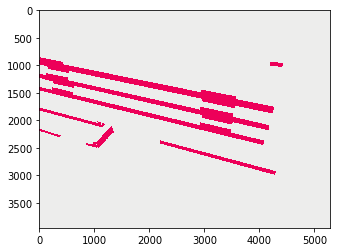

Extracted contours: 


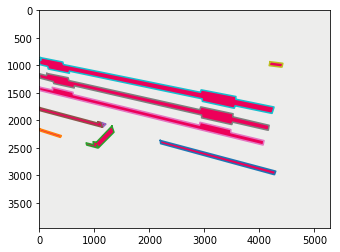

In [6]:
window_file = predictions_dir2 + filename.split(".")[0] +".png"

print("Window predictions: ")
image = cv2.imread(window_file)
plt.imshow(image)
plt.show()

#Extract the contours of the window file
contours = contour_extraction.extract_contours(window_file)

#Create polygons from the window contours
window_polygons = utils.convert_polygons_shapely(contours)


def plot_shapely_polys(image_file, polys):
    for poly in polys:
        s = poly
        s = poly.simplify(0.1, preserve_topology=True)
        x,y = s.exterior.xy
        plt.plot(x,y)
    plt.show()

print("Extracted contours: ")
plt.imshow(image)
plot_shapely_polys(window_file, window_polygons)

Finally, for each window point, we obtain its 3D coordinates and use them to calculate the window to wall ratio.

In [7]:
camera = camera_dict[filename]
pmatrix = camera.calc_pmatrix()

image_file = utils.load_image(image_dir + filename)

#Projects the merged polygon facades onto the camera image
projected_facades, projective_distances = extract_window_wall_ratio.project_merged_polygons(
    merged_polygons, offset, pmatrix)

#Creates a dictionary mapping the facade to the windows contained within them, keyed by facade index
facade_window_map = extract_window_wall_ratio.get_facade_window_map(
    window_polygons, projected_facades, projective_distances)

#Creates a list of all the facades in the merged polygon
facades = []
for poly in merged_polygons:
    facades = facades + poly

facade_indices = list(facade_window_map.keys())
for i in facade_indices:
    #Computes window to wall ratio
    win_wall_ratio = extract_window_wall_ratio.get_window_wall_ratio(
        projected_facades[i], facades[i], facade_window_map[i])

    #Output printing:
    print("Facade index: " + str(i))
    print("Window-to-wall ratio: " + str(win_wall_ratio))
    
    #Uncomment this line to plot the windows and facades on the image
    extract_window_wall_ratio.plot_windows_facade(projected_facades[i], facade_window_map[i], image_file)

facade_area: 969.098805348937
None
window_area: nan
None
Facade index: 3
Window-to-wall ratio: 0


/Users/akprakash/Programming/autobfe/a3dbr/image_processing/extract_window_wall_ratio.py:106: RuntimeWarning: invalid value encountered in true_divide
  return v / np.linalg.norm(v)


facade_area: 1157.58203125
None
window_area: nan
None
Facade index: 5
Window-to-wall ratio: 0


In [8]:
window_total_area = 0
for window in window_polygons:
    window_total_area+=window.area
facade_total_area = 0
for facade in projected_facades:
    facade_total_area+=facade.area
print(window_total_area)
print(facade_total_area)
print("total wwr = {}".format(window_total_area/facade_total_area))

1648235.5
1774285.0
total wwr = 0.9289575800956441


In [14]:
window_polygons

In [15]:
projected_facades

In [ ]:
for facade in projected_facades:
    print(shapely.geometry.mapping(facade))
#     print(facade.area)

In [ ]:
# shapely.geometry.mapping(window)

In [31]:
for facade_idx in facade_window_map:
    facade = projected_facades[facade_idx]
    windows = facade_window_map.get(facade_idx)
    facade_window_area = 0
    for window in windows:
        facade_window_area+=window.area
    print(facade.area, facade_window_area, facade_window_area/facade.area)

285663.5 363549.5 1.2726494634421268
265348.5 1002571.5 3.7783198322206455


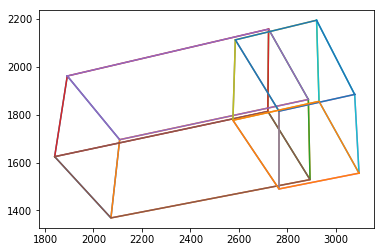

In [37]:

for facade in projected_facades:
#     plt.figure()
    x,y = facade.exterior.xy
    plt.plot(x,y)
# plt.plot(projected_facades[0].exterior.xy)



In [66]:
facade_coordinates = []
for facade in projected_facades:
    facade_coordinates.append(shapely.geometry.mapping(facade).get('coordinates')[0][:-1])
    print(shapely.geometry.mapping(facade).get('coordinates')[0][:-1])
print(facade_coordinates)

((1892.0, 1962.0), (1840.0, 1625.0), (2072.0, 1369.0), (2108.0, 1696.0))
((2108.0, 1696.0), (2072.0, 1369.0), (2893.0, 1529.0), (2886.0, 1864.0))
((2886.0, 1864.0), (2893.0, 1529.0), (2719.0, 1814.0), (2722.0, 2158.0))
((2722.0, 2158.0), (2719.0, 1814.0), (1840.0, 1625.0), (1892.0, 1962.0))
((1892.0, 1962.0), (2108.0, 1696.0), (2886.0, 1864.0), (2722.0, 2158.0))
((1840.0, 1625.0), (2072.0, 1369.0), (2893.0, 1529.0), (2719.0, 1814.0))
((3077.0, 1885.0), (3095.0, 1556.0), (2765.0, 1490.0), (2765.0, 1815.0))
((2765.0, 1815.0), (2765.0, 1490.0), (2575.0, 1777.0), (2585.0, 2113.0))
((2585.0, 2113.0), (2575.0, 1777.0), (2930.0, 1856.0), (2920.0, 2195.0))
((2920.0, 2195.0), (2930.0, 1856.0), (3095.0, 1556.0), (3077.0, 1885.0))
((3077.0, 1885.0), (2765.0, 1815.0), (2585.0, 2113.0), (2920.0, 2195.0))
((3095.0, 1556.0), (2765.0, 1490.0), (2575.0, 1777.0), (2930.0, 1856.0))
[((1892.0, 1962.0), (1840.0, 1625.0), (2072.0, 1369.0), (2108.0, 1696.0)), ((2108.0, 1696.0), (2072.0, 1369.0), (2893.0, 152

In [54]:
len(facade_coordinates)
projected_facades

In [69]:
for polygon in facade_coordinates:
    tup = coordinate[0]
    found = False
    for tup in polygon:
        print("searching for "+str(tup))
        connected_polys = []
        for polygon2 in facade_coordinates:
            tup2 = polygon2[0]
            if polygon != polygon2 and tup == tup2:
                print(polygon, polygon2)
                connected_polys.append(polygon2)
    print()

searching for (1892.0, 1962.0)
((1892.0, 1962.0), (1840.0, 1625.0), (2072.0, 1369.0), (2108.0, 1696.0)) ((1892.0, 1962.0), (2108.0, 1696.0), (2886.0, 1864.0), (2722.0, 2158.0))
searching for (1840.0, 1625.0)
((1892.0, 1962.0), (1840.0, 1625.0), (2072.0, 1369.0), (2108.0, 1696.0)) ((1840.0, 1625.0), (2072.0, 1369.0), (2893.0, 1529.0), (2719.0, 1814.0))
searching for (2072.0, 1369.0)
searching for (2108.0, 1696.0)
((1892.0, 1962.0), (1840.0, 1625.0), (2072.0, 1369.0), (2108.0, 1696.0)) ((2108.0, 1696.0), (2072.0, 1369.0), (2893.0, 1529.0), (2886.0, 1864.0))

searching for (2108.0, 1696.0)
searching for (2072.0, 1369.0)
searching for (2893.0, 1529.0)
searching for (2886.0, 1864.0)
((2108.0, 1696.0), (2072.0, 1369.0), (2893.0, 1529.0), (2886.0, 1864.0)) ((2886.0, 1864.0), (2893.0, 1529.0), (2719.0, 1814.0), (2722.0, 2158.0))

searching for (2886.0, 1864.0)
searching for (2893.0, 1529.0)
searching for (2719.0, 1814.0)
searching for (2722.0, 2158.0)
((2886.0, 1864.0), (2893.0, 1529.0), (2719